In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import hybrid_functions as motor

Set engine parameters

In [2]:
VOL_TANK = 0.055 ** 2 * 3.14 * 0.7 # tank volume (m^3)
HEAD_SPACE = 0.20              # initial vapour phase proportion

# Number of injector orifices
NUM_INJ = 12                 # number of primary injector orifices
DIA_INJ = 0.0015             # diameter of primary injector orifices (m)

DIA_PORT = 0.04              # diameter of fuel port (m)
LENGTH_PORT = 0.7            # length of fuel port (m)
DIA_FUEL = 0.07              # Outside diameter of fuel grain (m)
C_STAR_EFFICIENCY = 0.95     # Ratio between actual and theoretical
                             # characteristic velocity

DIA_THROAT = 0.02            # nozzle throat diameter (m)
DIA_NOZZLE = 0.07
NOZZLE_EFFICIENCY = 0.97     # factor by which to reduce thrust coefficient
# NOZZLE_AREA_RATIO = (DIA_NOZZLE ** 2) / (DIA_THROAT ** 2)        # ratio of nozzle exit area to throat area
NOZZLE_AREA_RATIO = 3        # ratio of nozzle exit area to throat area

DIA_FEED = 0.01               # feed pipe diameter (m)
LENGTH_FEED = 0.2             # feed pipe length (m)
VALVE_MODEL_TYPE = 'ball'     # either 'kv' or 'ball' (models as thick orifice)
KV_VALVE = 5                  # used if VALVE_MODEL_TRY='kv'
DIA_VALVE = 0.006             # used if VALVE_MODEL_TRY='ball'
LENGTH_VALVE = 0.1           # used if VALVE_MODEL_TRY='ball'

DENSITY_FUEL = 1005            # solid fuel density (kg m^-3)
# REG_COEFF = 0.1267      # regression rate coefficient (usually 'a' in
# REG_EXP = 0.3728          # regression rate exponent (usually 'n' in
REG_COEFF = 0.038 / 1000
REG_EXP = 0.5
    
PRES_EXTERNAL = 101325        # external atmospheric pressure at test site (Pa)
temp = 25 + 273.15            # initial tank temperature (K)

Run simulation

In [3]:

# Create pipes for pipe-like things
port   = motor.Pipe(DIA_PORT, LENGTH_PORT)
fuel   = motor.Pipe(DIA_FUEL)
throat = motor.Pipe(DIA_THROAT)
feed   = motor.Pipe(DIA_FEED, LENGTH_FEED)
valve  = motor.Pipe(DIA_VALVE, LENGTH_VALVE)


###############################################################################
# Initialize simulation
###############################################################################

dt = 1e-2  # time step (s)

#open propep data file
propep_file = open('data/L_Nitrous_S_HDPE.propep', 'r')
propep_data = propep_file.readlines()

#open compressibility_data csv file
with open('data/n2o_compressibility_factors.csv') as csvfile:
    compressibility_data = csv.reader(csvfile)
    pdat, zdat = motor.compressibility_read(compressibility_data)

# assign initial values
vapz_lag = 0
time = 0
mdotox = 0
impulse = 0
gamma_N2O = 1.31
blowdown_type = 'liquid'

# temperature dependent properties
lden, vden, hl, hg, cp, vap_pres, ldynvis = motor.thermophys(temp)

hv = hg - hl # spec heat of vapourization
pres_cham = PRES_EXTERNAL

#calculate initial propellant masses
lmass = VOL_TANK * (1 - HEAD_SPACE) * lden
vmass = VOL_TANK * HEAD_SPACE * vden
fuel_mass = (fuel.A - port.A) * port.l * DENSITY_FUEL
tmass = lmass + vmass

(  # create empty lists to fill with output data
    time_data,
    vap_pres_data,
    pres_cham_data,
    thrust_data,
    gox_data,
    prop_mass_data,
    manifold_pres_data,
    gamma_data,
    throat_data,
    nozzle_efficiency_data,
    exit_pressure_data,
    area_ratio_data,
    of_data,
    regression_data,
    port_diameter_data,
    isp_data,
    nox_flow_data,

    # additional properties needed for the 6DOF simulation
    vden_data, vmass_data,
    lden_data, lmass_data,
    fuel_mass_data
) = [[] for _ in range(22)]

# print initial conditions
print(f"""
Initial conditions:
    time: {time:.4f} s
    tank temperature: {temp-273.15:.2f} C
    lmass: {lmass:.4f} kg
    vmass: {vmass:.4f} kg
    vap_pres {vap_pres:.4f} Pa
    fuel thickness: {0.5 * (DIA_FUEL-DIA_PORT):.4f} m
    fuel mass {fuel_mass:.4f} kg
""")

###############################################################################
# Simulation loop
###############################################################################

while True:
    time += dt  # increment time

    # calculate feed system losses (only attemped for liquid phase)
    if mdotox > 0 and lmass > 0:
        flow_speed = mdotox / (lden * feed.A)
        entry_loss = 0.5 * lden * (flow_speed ** 2)  # loss at tank entry

        reynolds = lden * flow_speed * feed.d / ldynvis
        f = motor.Nikuradse(reynolds)

        # loss in pipe
        vis_pdrop = 0.25 * f * lden * (flow_speed**2) * feed.l / feed.d

        if VALVE_MODEL_TYPE == 'ball':
            #valve loss from full bore ball valve modelled as thick orifice
            valve_loss = (0.5 * lden * flow_speed * flow_speed
                          * motor.ball_valve_K(reynolds, feed.d, valve.d,
                                               valve.l))

        elif VALVE_MODEL_TYPE == 'kv':
            valve_loss = (1.296e9 * mdotox * mdotox /
                          (lden * KV_VALVE * KV_VALVE))

        # sum pressure drops
        manifold_pres = vap_pres - entry_loss - valve_loss - vis_pdrop
    else:
        manifold_pres = vap_pres


    #calculate injector pressure drop
    inj_pdrop = manifold_pres - pres_cham

    if inj_pdrop < 0.15 and time > 0.5:
        print(f'FAILURE: Reverse flow occurred at t={time} s')
        break

    # model tank emptying

    if blowdown_type == 'liquid':
        # liquid phase blowdown

        mdotox = NUM_INJ * motor.dyer_injector(
            pres_cham, DIA_INJ, lden, inj_pdrop,
            hl, manifold_pres, vap_pres
        )

        # find new mass of tank contents after outflow
        tmass -= mdotox * dt

        # liquid mass prior to vaporization
        lmass_pre_vap = lmass - (mdotox * dt)

        # lmass post vaporization
        lmass_post_vap = (vden * VOL_TANK - tmass) / (vden / lden - 1)

        if lmass_pre_vap < lmass_post_vap:  # check for liquid depletion
            print(f'starting vapour blowdown, vapour mass is {vmass+lmass:.4f} kg')
            print(f'injector pressure drop at liquid depletion was '
                  f'{100 * inj_pdrop / pres_cham:.4f}%')

            blowdown_type = 'vapour'
            lmass = 0
            vmass = tmass

            # define tank parameters at liquid depletion
            vmass_ld, temp_ld, vden_ld, vap_pres_ld = (vmass, temp,
                                                       vden, vap_pres)

            Z_ld = np.interp(motor.thermophys(temp_ld)[5], pdat, zdat)

        else:  # continue with liquid blowdown stage
            lmass = lmass_post_vap
            vapz = lmass_pre_vap - lmass  # mass vapourized

            # add 1st order lag of 0.15s to model vaporization time
            vapz_lag = dt / 0.15 * (vapz - vapz_lag) + vapz_lag
            vmass = tmass - lmass

            # update nitrous thermophysical properties given new temperature
            temp -= vapz_lag * hv / lmass / cp
            lden, vden, hl, hg, cp, vap_pres, ldynvis = motor.thermophys(temp)
            hv = hg - hl  # spec heat of vapourization

    else:
        # vapour phase blowdown

        # calculations for injector orifices
        mdotox = NUM_INJ * motor.vapour_injector(DIA_INJ, vden, inj_pdrop)
        vmass -= dt * mdotox  # sum flow from 3 types of orifice

        # find current tank vapour parameters
        Z2 = motor.Z2_solve(temp_ld, Z_ld, vmass_ld, vmass, gamma_N2O,
                            zdat, pdat)

        if Z2 == 'numerical instability':
            print('vapour depleted: finishing motor simulation')
            break

        #isentropic assumption
        temp = temp_ld * pow(Z2 * vmass / (Z_ld * vmass_ld), gamma_N2O-1)
        vap_pres = vap_pres_ld * pow(temp / temp_ld, gamma_N2O / (gamma_N2O-1))
        vden = vden_ld * pow(temp / temp_ld, 1 / (gamma_N2O-1))

    # check for excessive mass flux
    if mdotox / port.A > 600:
        print(f'Failure: oxidizer flux too high: {mdotox / port.A:.2f}')
        # break

    # fuel port calculation
    rdot = REG_COEFF * pow(mdotox/port.A, REG_EXP)
    mdotfuel = rdot * DENSITY_FUEL * np.pi * port.d * port.l

    port.d += 2*rdot*dt

    if port.d > fuel.d: #check for depleted fuel grain
        print("fuel depleted")
        break

    fuel_mass = (fuel.A - port.A) * port.l * DENSITY_FUEL


    # lookup characteristic velocity using previous
    # pres_cham and current OF from propep data
    c_star = (motor.c_star_lookup(pres_cham, mdotox / mdotfuel, propep_data)
              * C_STAR_EFFICIENCY)

    # calculate current chamber pressure
    pres_cham = (mdotox + mdotfuel) * c_star / throat.A

    # lookup ratio of specific heats from propep data file
    gamma = motor.gamma_lookup(pres_cham, mdotox/mdotfuel, propep_data)


    # performance calculations
    # find nozzle exit static pressure
    mach_exit = motor.mach_exit(gamma, NOZZLE_AREA_RATIO)
    pres_exit = pres_cham * pow(1 + (gamma - 1) * mach_exit * mach_exit * 0.5,
                                -gamma / (gamma - 1))


    # motor performance calculations
    thrust = NOZZLE_EFFICIENCY * (
        throat.A * pres_cham * np.sqrt(
            2 * gamma**2 / (gamma - 1)
            * pow(2 / (gamma + 1), (gamma + 1) / (gamma - 1))
            * (1 - pow(pres_exit / pres_cham, 1 - 1 / gamma))
        ) + (pres_exit - PRES_EXTERNAL) * throat.A * NOZZLE_AREA_RATIO)


    #update data lists
    time_data.append(time)
    vap_pres_data.append(vap_pres)
    pres_cham_data.append(pres_cham)
    manifold_pres_data.append(manifold_pres)
    thrust_data.append(thrust)
    gox_data.append(mdotox / port.A)
    prop_mass_data.append(lmass + vmass + fuel_mass)
    gamma_data.append(gamma)
    throat_data.append(DIA_THROAT)
    nozzle_efficiency_data.append(NOZZLE_EFFICIENCY)
    exit_pressure_data.append(pres_exit)
    area_ratio_data.append(NOZZLE_AREA_RATIO)
    of_data.append(mdotox/mdotfuel)
    regression_data.append(rdot)
    port_diameter_data.append(port.d)
    nox_flow_data.append(mdotox)

    #additional data for the 6DOF simulation
    vmass_data.append(vmass)
    vden_data.append(vden)
    lden_data.append(lden)
    lmass_data.append(lmass)
    fuel_mass_data.append(fuel_mass)
    
#print final results
print("\nFinal conditions:\ntime:", time, "s\ntank temperature:", temp-273.15,
      "C\nlmass:", lmass, "kg\nvmass:", vmass, "kg\nvap_pres:", vap_pres,
      'Pa\nfuel thickness:', (DIA_FUEL-port.d)/2, 'm\nfuel mass', fuel_mass,
      'kg')

impulse = dt * sum(thrust_data[:len(time_data)])

print('\nPerformance results:\nInitial thrust:', thrust_data[int(0.5/dt)],
      'N\nmean thrust:', np.mean(thrust_data), 'N\nimpulse:', impulse,
      'Ns\nmean Isp:', impulse/(prop_mass_data[0]-fuel_mass)/9.81)
print(
f"""\nMidburn Results:
O/F: {of_data[len(of_data) // 2]}
Regression: {regression_data[len(regression_data) // 2]}
Pressure margin: {np.min( ( np.array(manifold_pres_data) - np.array(pres_cham_data) ) / np.array(pres_cham_data) )}
""")


###############################################################################
# generate motor_output.csv for trajectory simulation
###############################################################################
with open("motor_out.csv", "w", newline='') as motor_file:
    motor_file.truncate()
    motor_write = csv.writer(motor_file)
    motor_write.writerow([
        'Time',
        'Propellant mass (kg)',
        'Chamber pressure (Pa)',
        'Throat diameter (m)',
        'Nozzle inlet gamma',
        'Nozzle efficiency',
        'Exit static pressure (Pa)',
        'Area ratio',
        'Vapour Density (kg/m^3)',
        'Vapour Mass (kg)',
        'Liquid Density (kg/m^3)',
        'Liquid Mass (kg)',
        'Solid Fuel Mass (kg)',
        'Solid Fuel Density (kg/m^3)',
        'Solid Fuel Outer Diameter (m)',
        'Solid Fuel Length (m)'
    ])

    for i, _ in enumerate(time_data):
        motor_write.writerow([time_data[i], prop_mass_data[i],
                              pres_cham_data[i],
                              throat_data[i], gamma_data[i],
                              nozzle_efficiency_data[i], exit_pressure_data[i],
                              area_ratio_data[i],
                              vden_data[i], vmass_data[i],
                              lden_data[i], lmass_data[i], fuel_mass_data[i],
                              DENSITY_FUEL, DIA_FUEL, LENGTH_PORT])

    motor_write.writerow([time_data[-1] + dt, fuel_mass, pres_cham_data[-1],
                          throat_data[-1], gamma_data[-1],
                          nozzle_efficiency_data[-1], exit_pressure_data[-1],
                          area_ratio_data[-1],
                          vden_data[-1], 0,
                          lden_data[-1], lmass_data[-1], fuel_mass_data[-1],
                          DENSITY_FUEL, DIA_FUEL, LENGTH_PORT])


Initial conditions:
    time: 0.0000 s
    tank temperature: 25.00 C
    lmass: 3.9568 kg
    vmass: 0.2527 kg
    vap_pres 5659941.3109 Pa
    fuel thickness: 0.0150 m
    fuel mass 1.8233 kg

starting vapour blowdown, vapour mass is 0.8410 kg
injector pressure drop at liquid depletion was 28.6493%
vapour depleted: finishing motor simulation

Final conditions:
time: 9.12999999999985 s
tank temperature: -88.32284864121317 C
lmass: 0 kg
vmass: 0.15771376114400398 kg
vap_pres: 662219.2571666626 Pa
fuel thickness: 0.009580148022176015 m
fuel mass 1.2792807085537141 kg

Performance results:
Initial thrust: 1637.3829672020615 N
mean thrust: 999.8154214501583 N
impulse: 9118.316643625454 Ns
mean Isp: 195.80904584720548

Midburn Results:
O/F: 8.264714238713625
Regression: 0.0007091782143102707
Pressure margin: 0.2871927515528946



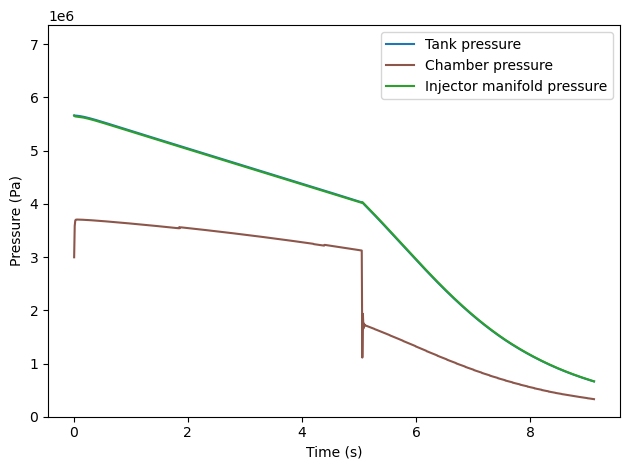

In [4]:
#plot pressures
plt.plot(time_data, vap_pres_data, 'C0', label='Tank pressure')
plt.plot(time_data, pres_cham_data, 'C5', label='Chamber pressure')
plt.plot(time_data, manifold_pres_data, 'C2', label='Injector manifold pressure')
plt.ylabel('Pressure (Pa)')
plt.ylim(0, max(vap_pres_data)*1.3)
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.tight_layout()
plt.show()



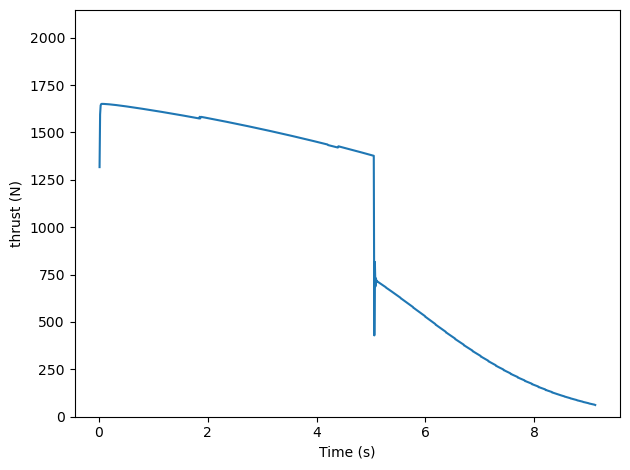

In [5]:
#plot thrust
plt.plot(time_data, thrust_data)
plt.xlabel('Time (s)')
plt.ylabel('thrust (N)')
plt.ylim(0, max(thrust_data)*1.3)
plt.tight_layout()
plt.show()

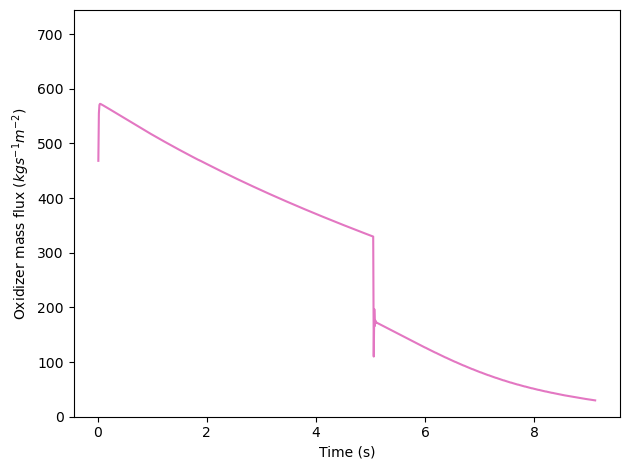

In [6]:
#plot massflux
plt.plot(time_data, gox_data, 'C6')
plt.xlabel('Time (s)')
plt.ylabel('Oxidizer mass flux ($kg s^{-1} m^{-2}$)')
plt.ylim(0, max(gox_data)*1.3)
plt.tight_layout()
plt.show()

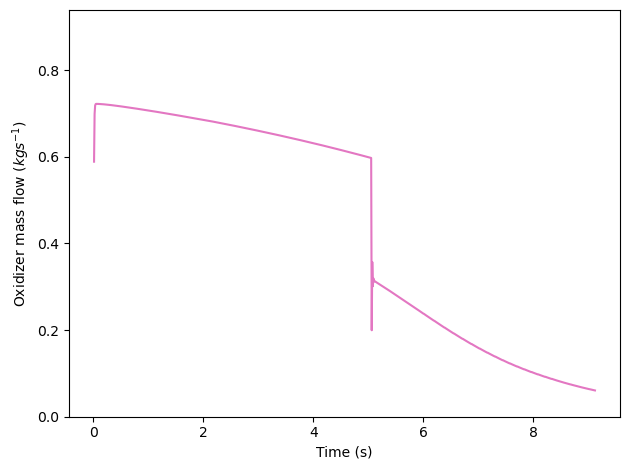

In [7]:
#plot nox flow
plt.plot(time_data, nox_flow_data, 'C6')
plt.xlabel('Time (s)')
plt.ylabel('Oxidizer mass flow ($kg s^{-1}$)')
plt.ylim(0, max(nox_flow_data)*1.3)
plt.tight_layout()
plt.show()

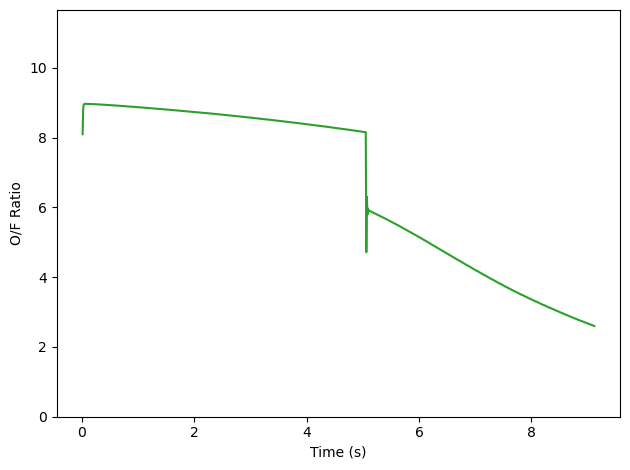

In [8]:
#plot O/F
plt.plot(time_data, of_data, 'C2')
plt.xlabel('Time (s)')
plt.ylabel('O/F Ratio')
plt.ylim(0, max(of_data)*1.3)
plt.tight_layout()
plt.show()

Set trajectory simulation parameters

In [9]:
MASS_DRY = 22                     #rocket dry mass (kg)
DIAMETER = 0.13                  #rocket body DIAMETER (m)
LAUNCH_ALT = 180                    #launch altitude (msl)
ANGLE_RAIL = 85                   #launch rail angle, degrees
LENGTH_RAIL = 12                  #launch rail length (m)

vvel = 0                          #initial rocket vertical velocity (m s^-1)
hvel = 0                          #initial rocket horizontal velocity (m s^-1)
ground = 0                          #initial down-range distance (m)


# simulation time step
STEP = 0.01                        #time step (s)

Run simulation

In [10]:
# open motor performance file (output of motor_sim.py)
with open('motor_out.csv') as csvfile:
    motor_out = csv.reader(csvfile)

    (motor_time_data, prop_mass_data, cham_pres_data,
     throat_data, gamma_data, nozzle_efficiency_data,
     exit_pres_data, area_ratio_data) = [], [], [], [], [], [], [], []

    next(motor_out)
    for row in motor_out:
        motor_time_data.append(float(row[0]))
        prop_mass_data.append(float(row[1]))
        cham_pres_data.append(float(row[2]))
        throat_data.append(float(row[3]))
        gamma_data.append(float(row[4]))
        nozzle_efficiency_data.append(float(row[5]))
        exit_pres_data.append(float(row[6]))
        area_ratio_data.append(float(row[7]))

# open standard atmosphere data
with open('data/atmosphere_data.csv') as csvfile:
    standard_atmo_data = csv.reader(csvfile)
    adat, ddat, sdat, padat = [], [], [], []
    next(standard_atmo_data)
    for row in standard_atmo_data:
        adat.append(float(row[0]))
        ddat.append(float(row[1]))
        sdat.append(float(row[2]))
        padat.append(float(row[3]))

# import drag coeffcient as a function of Mach data
with open('data/drag_coefficient_data.csv') as csvfile:
    drag_coefficient_data = csv.reader(csvfile)
    machdat = []
    cddat = []
    next(drag_coefficient_data)
    for row in drag_coefficient_data:
        machdat.append(float(row[0]))
        cddat.append(float(row[1]))

# compute state of vehicle
apogee = False; GRAV_ACCEL = 9.81; alt = LAUNCH_ALT; stable = True; rail_left = False; time = 0
vel = np.sqrt((vvel**2)+(hvel**2))
pitch = np.radians(ANGLE_RAIL)
if alt < 80000:
    density = np.interp(alt, adat, ddat)
    vsound = np.interp(alt, adat, sdat)
    pres_static = np.interp(alt, adat, padat)
else:
    density, vsound = 0, float("inf")
mach = vel/vsound

# create empty lists to fill with output data
(time_data, alt_data, vel_data, acc_data, drag_data, thrust_data, mass_data,
 mach_data, ground_data, pitch_data) = [], [], [], [], [], [], [], [], [], []


###############################################################################
# Simulation loop
###############################################################################
while True:
    time += STEP

    # Update density(altitude), speed of sound(altitude), and cd(mach) from input data
    if alt < 80000:
        density = np.interp(alt, adat, ddat)
        vsound = np.interp(alt, adat, sdat)
        pres_static = np.interp(alt, adat, padat)

    else:
        density, vsound, pres_static = 0, float("inf"), 0

    cd = np.interp(mach, machdat, cddat)

    # Find current thrust
    if time < max(motor_time_data):
        pres_cham = np.interp(time, motor_time_data, cham_pres_data)
        dia_throat = np.interp(time, motor_time_data, throat_data)
        gamma = np.interp(time, motor_time_data, gamma_data)
        nozzle_efficiency = np.interp(time, motor_time_data, nozzle_efficiency_data)
        pres_exit = np.interp(time, motor_time_data, exit_pres_data)
        nozzle_area_ratio = np.interp(time, motor_time_data, area_ratio_data)

        # motor performance calculations
        area_throat = ((dia_throat/2)**2)*np.pi
        thrust = (area_throat*pres_cham*(((2*gamma**2/(gamma-1))
                                         *((2/(gamma+1))**((gamma+1)/(gamma-1)))
                                         *(1-(pres_exit/pres_cham)**((gamma-1)/gamma)))**0.5)
                 +(pres_exit-pres_static)*area_throat*nozzle_area_ratio)

        thrust *= nozzle_efficiency
    else:
        thrust = 0

    #update acceleration and integrate
    mass_prop = np.interp(time, motor_time_data, prop_mass_data)
    mass = mass_prop + MASS_DRY
    drag = 0.5*cd*density*(vel**2)*(((DIAMETER/2)**2)*np.pi)
    vacc = ((thrust*np.sin(pitch))/mass)-((drag*np.sin(pitch))/mass)-GRAV_ACCEL
    hacc = ((thrust*np.cos(pitch))/mass)-((drag*np.cos(pitch))/mass)
    vvel += vacc*STEP
    hvel += hacc*STEP
    vel = np.sqrt((vvel**2)+(hvel**2))
    acc = np.sqrt((vacc**2)+(hacc**2))

    if alt-LAUNCH_ALT < np.sin(pitch)*LENGTH_RAIL and apogee == False:
        pitch = np.radians(ANGLE_RAIL)
    else:
        pitch = np.arctan2(vvel, hvel)
        if rail_left == False:
            print('rail cleared at', vel, 'm/s', 'T/W:', thrust/(mass*GRAV_ACCEL))
            rail_left = True

    mach = vel/vsound
    alt += vvel*STEP
    ground += hvel*STEP

    # check for ground impact
    if alt < 0:
        break

    #update trajectory plot _data
    time_data.append(time)
    thrust_data.append(thrust)
    drag_data.append(-drag)
    alt_data.append(alt)
    vel_data.append(vel)
    acc_data.append(acc)
    mass_data.append(mass)
    mach_data.append(mach)
    ground_data.append(ground)
    pitch_data.append(np.degrees(pitch))

print('\nResults:\napogee:', (max(alt_data)-LAUNCH_ALT)/1000, 'km\nmax Mach:',
      max(mach_data))

print('Gross lift off mass:', mass_data[0], 'kg')

rail cleared at 34.946381692497866 m/s T/W: 6.052869619471466

Results:
apogee: 3.2300992133744417 km
max Mach: 0.7100072085474952
Gross lift off mass: 28.026211620659215 kg


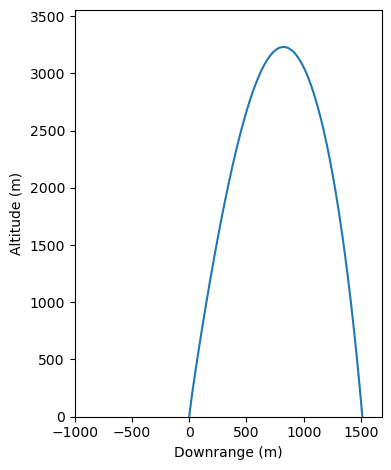

In [11]:
# plot Altitude
plt.plot(ground_data, [a-LAUNCH_ALT for a in alt_data])
plt.xlabel('Downrange (m)')
plt.ylabel('Altitude (m)')
plt.ylim(0, max([a-LAUNCH_ALT for a in alt_data])*1.1)
plt.xlim(-1000, (max(ground_data)*1.1))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

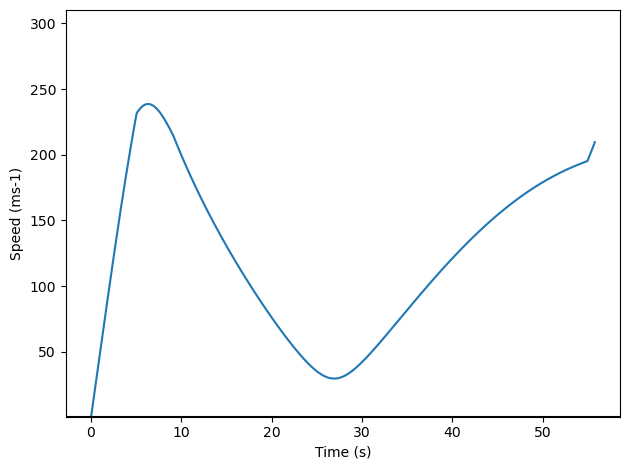

In [12]:
# plot Velocity
plt.plot(time_data, vel_data)
plt.xlabel('Time (s)')
plt.ylabel('Speed (ms-1)')
plt.ylim(min(vel_data)*1.3, max(vel_data)*1.3)
plt.axhline(y=0, color='k', linestyle='-')
plt.tight_layout()
plt.show()